# Case Study: Model Robustness

In [ ]:
#hide
#skip
! [[ -e /content ]] && git clone https://github.com/chfc-cmi/misas && cd misas && pip install .
%cd misas

/data3/ankenbrand/misas/misas


In [ ]:
#hide
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Aim: How robust is my network to shifts in data

We often find ourselves in a situation where we have trained a model for a certain task. The network performs well on the training and validation data. It also performs good on the hold out test set. Still you wonder what happens when you feed it data that is systematically different from all three sets? Does it make sense to re-train with more extensive data augmentation?

In this case study we demonstrate how `misas` helps answer these questions with a concrete example:
 - **Model**: Custom U-Net
 - **Data**: Small set of transversal CMR images

## Prepare Model for `misas`

In [ ]:
from fastai.vision import *

In [ ]:
class Fastai1_model:
    def __init__(self, path, model):
        self.trainedModel = torch.hub.load(path,model)
        # self.trainedModel = load_learner(path,model) # if it were local
        self.resize256 = lambda x: x.resize(256)
        
    def prepareSize(self, item):
        return self.resize256(item)
    
    def predict(self, image):
        return self.trainedModel.predict(image)

# model = Fastai1_model('example/b0','b0_transversal_5_5') # if it were local
model = Fastai1_model('chfc-cmi/transversal-cmr-seg','b0_transversal_5_5')

Using cache found in /home/ankenbrand/.cache/torch/hub/chfc-cmi_transversal-cmr-seg_master


## Prepare Dataset for `misas`

Data is available as png images and masks which is just fine for `misas`

torch.Size([3, 128, 128])

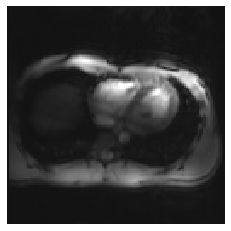

In [ ]:
img = open_image("example/b0/images/train_example.png")
img.show(figsize=(4,4))
img.shape

## How does the trained model perform on this (training) example?

Time to apply the model to the example image and see how it works (we need to call `prepareSize` manually here):

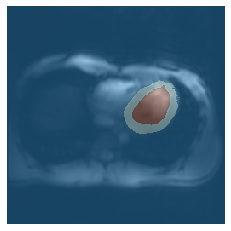

In [ ]:
img = model.prepareSize(img)
img.show(figsize=(4,4), y=model.predict(img)[0])

So how does it perform on validation data?

In [ ]:
from glob import glob
files = sorted(glob("example/b0/images/val*.png"))

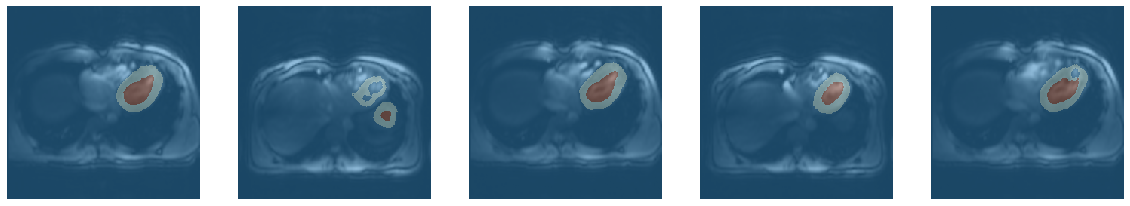

In [ ]:
fig, axs = plt.subplots(1,5, figsize=(20,10))
for i, ax in enumerate(axs.flatten()):
    fname = files[i]
    tmp = model.prepareSize(open_image(fname))
    tmp.show(ax=ax, y=model.predict(tmp)[0])

## Analysis of one image

In [ ]:
#hide
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from misas.core import *

### Sensitivity to orientation

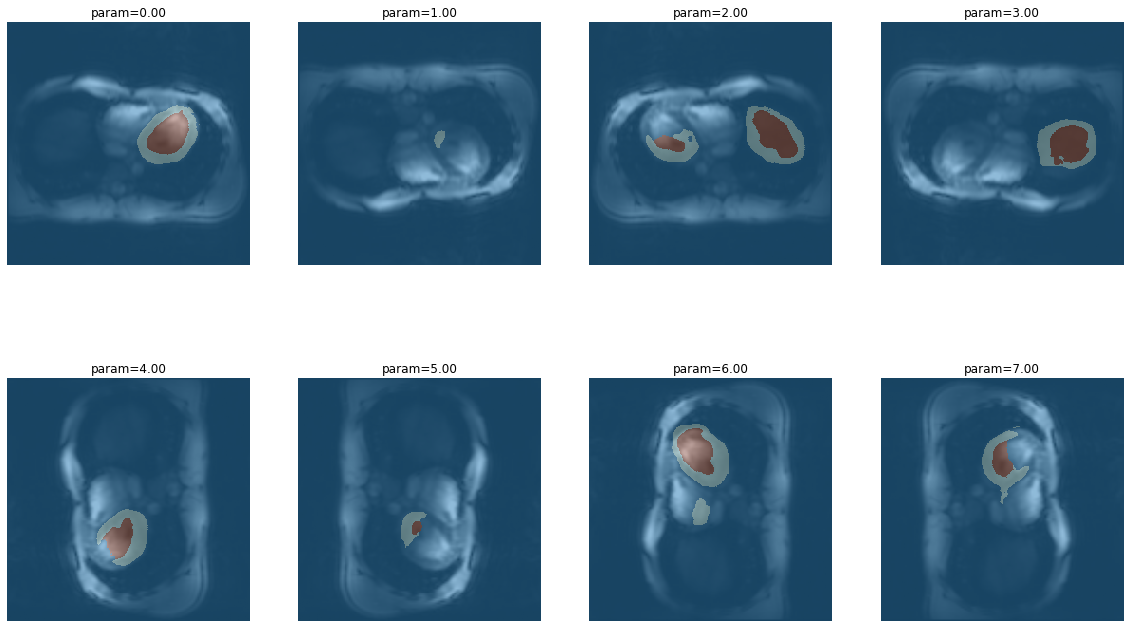

In [ ]:
plot_series(get_dihedral_series(img,model), nrow=2, figsize=(20,12))

Example of applying dihedral transformation function

In [ ]:
img = lambda: open_image(files[0]).resize(256)
trueMask = lambda: open_mask(files[0].replace("image","mask"))

### Sensitivity to rotation

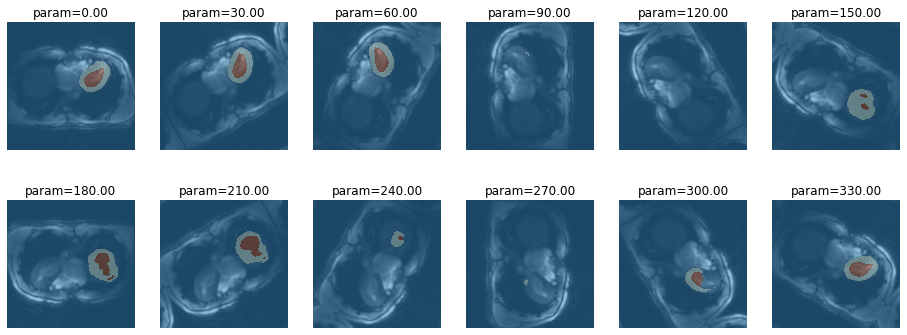

In [ ]:
plot_series(get_rotation_series(img(),model, step=30), nrow=2)

In [ ]:
results = eval_rotation_series(img(),trueMask(),model,components=["bg","LV","MY"])

In [ ]:
import altair as alt

In [ ]:
(alt
 .Chart(results.melt(id_vars=['deg'],value_vars=['LV','MY']))
 .mark_line()
 .encode(
     x="deg",
     y="value",
     color="variable",
     tooltip="value"
 )
 .properties(width=700,height=300)
 .interactive()
)

alt.Chart(...)

In [ ]:
gif_series(
    get_rotation_series(img(),model, start=1, end=360,step=10),
    "example/b0/rotation.gif",
    param_name="deg",
    duration=400
)

![segmentation sensitivity to rotation](example/b0/rotation.gif)

### Sensitivity to cropping

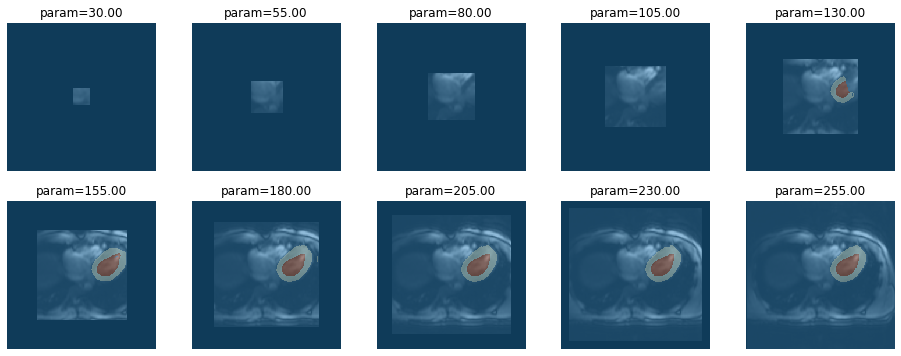

In [ ]:
plot_series(get_crop_series(img(),model, start = 30, end = 256, step = 25), nrow=2)

In [ ]:
results = eval_crop_series(img(),trueMask(),model,start = 5, components=["bg","LV","MY"])

In [ ]:
(alt
 .Chart(results.melt(id_vars=['pixels'],value_vars=['LV','MY']))
 .mark_line()
 .encode(
     x="pixels",
     y="value",
     color="variable",
     tooltip="value"
 )
 .properties(width=700,height=300)
 .interactive()
)

alt.Chart(...)

In [ ]:
gif_series(
    get_crop_series(img(),model, start=250, end=50,step=-10),
    "example/b0/crop.gif",
    param_name="pixels",
    duration=400
)

![segmentation sensitivity to rotation](example/b0/crop.gif)

### Sensitivity to brightness

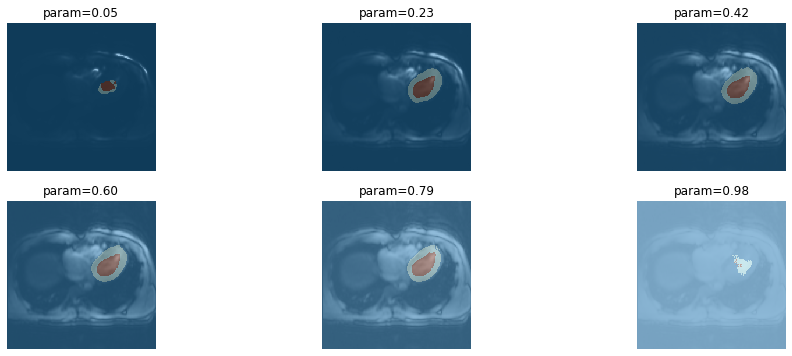

In [ ]:
plot_series(get_brightness_series(img(),model, end = 0.99, step = 0.185), nrow=2)

In [ ]:
results = eval_bright_series(img(),trueMask(),model, end = 0.99, components=["bg","LV","MY"])

In [ ]:
(alt
 .Chart(results.melt(id_vars=['brightness'],value_vars=['LV','MY']))
 .mark_line()
 .encode(
     x="brightness",
     y="value",
     color="variable",
     tooltip="value"
 )
 .properties(width=700,height=300)
 .interactive()
)

alt.Chart(...)

### Sensitivity to contrast

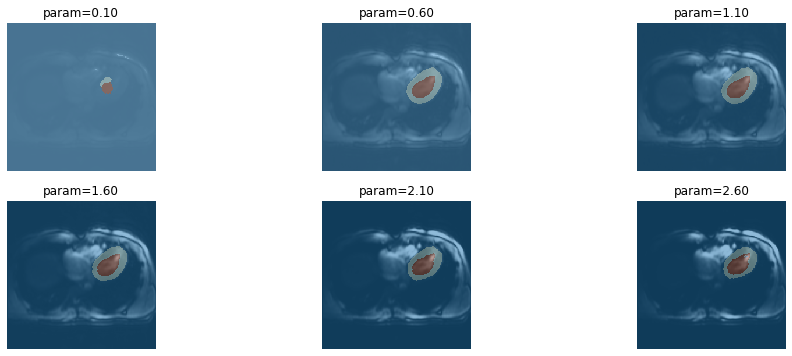

In [ ]:
plot_series(get_contrast_series(img(),model, start=0.1, end=3, step=0.5), nrow = 2)

In [ ]:
results = eval_contrast_series(img(),trueMask(),model, end = 2.5, step = 0.3, components=["bg","LV","MY"])

In [ ]:
(alt
 .Chart(results.melt(id_vars=['contrast'],value_vars=['LV','MY']))
 .mark_line()
 .encode(
     x="contrast",
     y="value",
     color="variable",
     tooltip="value"
 )
 .properties(width=700,height=300)
 .interactive()
)

alt.Chart(...)

In [ ]:
gif_series(
    get_contrast_series(img(),model, start=0.05, end=2.2,step=0.1),
    "example/b0/contrast.gif",
    param_name="contrast",
    duration=400
)

![segmentation sensitivity to contrast](example/b0/contrast.gif)

### Sensitivity to zoom

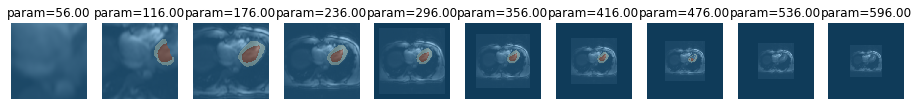

In [ ]:
plot_series(get_zoom_series(img(),model,end=600,step=60))

In [ ]:
results = eval_zoom_series(img(),trueMask(),model,end=600,step=100,components=["bg","LV","MY"])

## Something strange going on here

In [ ]:
results

,scale,bg,LV,MY
0,56,0.928616,0.000000,0.000000
1,156,0.958127,0.111611,0.163986
2,256,0.981503,0.084020,0.168519
3,356,0.990593,0.065180,0.174460
4,456,0.995422,0.090909,0.230061
5,556,0.998938,0.000000,0.000000


In [ ]:
(alt
 .Chart(results.melt(id_vars=['scale'],value_vars=['LV','MY']))
 .mark_line()
 .encode(
     x="scale",
     y="value",
     color="variable",
     tooltip="value"
 )
 .properties(width=700,height=300)
 .interactive()
)

alt.Chart(...)

In [ ]:
gif_series(
    get_zoom_series(img(),model, start=50, end=900,step=50),
    "example/b0/zoom.gif",
    param_name="scale",
    duration=400
)

![segmentation sensitivity to zoom](example/b0/zoom.gif)

## Sensitivity to MR artifacts

### Spike artifact

In [ ]:
from misas.mri import *

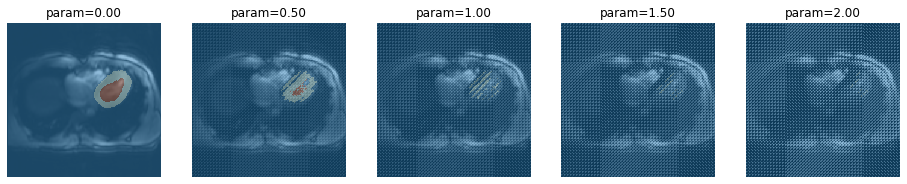

In [ ]:
plot_series(get_spike_series(img(),model))

[[0.0, Image (3, 256, 256), ImageSegment (1, 256, 256), None],
 [0.5, Image (3, 256, 256), ImageSegment (1, 256, 256), None],
 [1.0, Image (3, 256, 256), ImageSegment (1, 256, 256), None],
 [1.5, Image (3, 256, 256), ImageSegment (1, 256, 256), None],
 [2.0, Image (3, 256, 256), ImageSegment (1, 256, 256), None]]

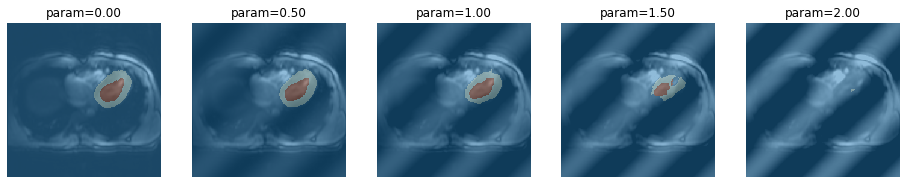

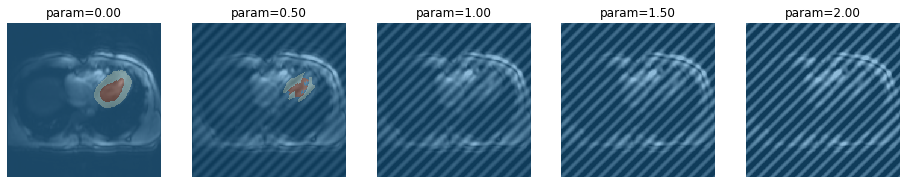

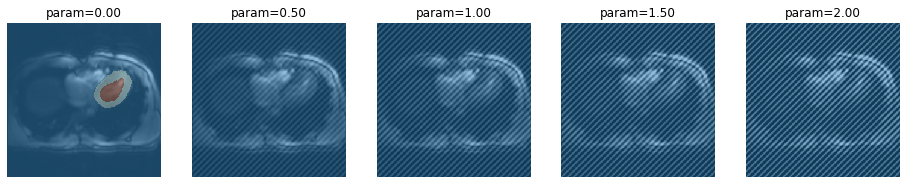

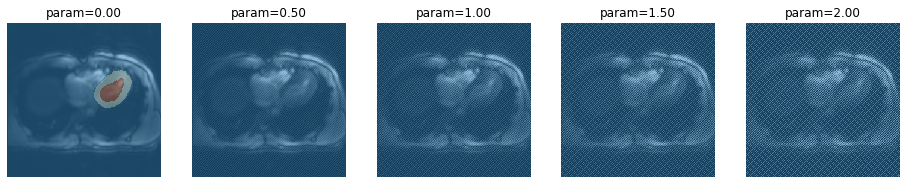

In [ ]:
for i in [.51,.55,.6,.75]:
    plot_series(get_spike_series(img(),model,spikePosition=[i,i]))

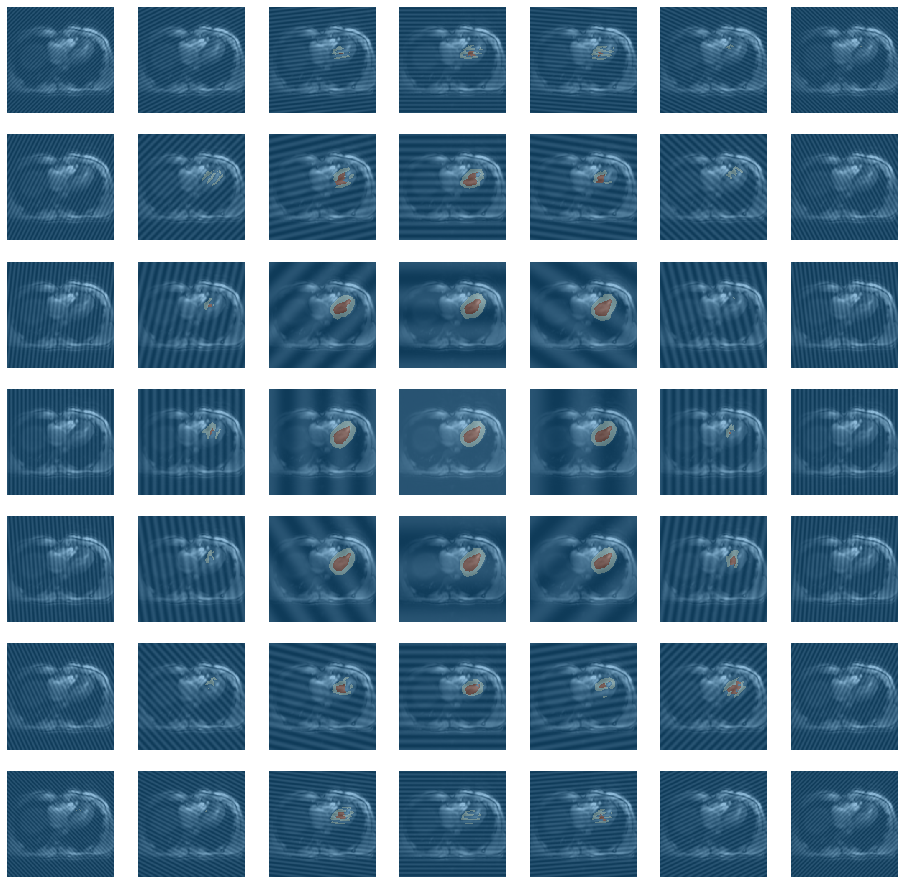

In [ ]:
fig, ax = plt.subplots(7,7,figsize=(16,16))
values = [.4,.45,.49,.5,.51,.55,.6]
for i,x in enumerate(values):
    for j,y in enumerate(values):
        im = img()
        im = spikeTransform(im,.5,[x,y])
        im.show(ax=ax[i,j], y=model.predict(im)[0])